In [ ]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 155685 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)

plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [ ]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Download the data


In [ ]:
!gdown --id 1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis
To: /content/1_구어체(1).xlsx
100% 15.8M/15.8M [00:00<00:00, 311MB/s]


In [ ]:
import pandas as pd

df = pd.read_excel('/content/1_구어체(1).xlsx')
df

,SID,원문,번역문
0,1,'Bible Coloring'은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 ...,Bible Coloring' is a coloring application that...
1,2,씨티은행에서 일하세요?,Do you work at a City bank?
2,3,푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다.,"PURITO's bestseller, which recorded 4th rough ..."
3,4,11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다.,In Chapter 11 Jesus called Lazarus from the to...
4,5,"6.5, 7, 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠습니다.",I would feel grateful to know how many stocks ...
...,...,...,...
199995,199996,나는 먼저 청소기로 바닥을 밀었어요.,"First of all, I vacuumed the floor."
199996,199997,나는 먼저 팀 과제를 하고 놀러 갔어요.,I did the team assignment first and went out t...
199997,199998,나는 비 같은 멋진 연예인을 좋아해요.,I like cool entertainer like Rain.
199998,199999,나는 멋진 자연 경치를 보고 눈물을 흘렸어.,I cried seeing the amazing scenery.


In [ ]:
def kor_preprocess(sent):
  sent = re.sub(r"([?.!,¿])", r" \1", sent)
  sent = re.sub(r"[^0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣!.?]+", r" ", sent)
  sent = re.sub(r"\s+", " ", sent)
  return sent

def eng_preprocess(sent):
  sent = re.sub(r"([?.!,¿])", r" \1", sent)
  sent = re.sub(r"[^0-9a-zA-Z!.?]+", r" ", sent)
  sent = re.sub(r"\s+", " ", sent)
  return sent

In [ ]:
kor_preprocess(df['원문'][0])

' Bible Coloring 은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 앱입니다 .'

In [ ]:
eng_preprocess(df['번역문'][0])

'Bible Coloring is a coloring application that allows you to experience beautiful stories in the Bible .'

In [ ]:
# 단순 tokenizer가 아닌 stem 쓸 수 있는 tokenizer를 써야 하나..?
src_line = []
# sents_kor_in, decoder_input, decoder_target = [], [], []
for sent in df['원문']:
  src_line.append(kor_preprocess(sent))

src_line

[' Bible Coloring 은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 앱입니다 .',
 '씨티은행에서 일하세요 ?',
 '푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다 .',
 '11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다 .',
 '6 .5 7 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠습니다 .',
 'F W 겐조타이거 키즈와 그리고 이번에 주문한 키즈 중 부족한 수량에 대한 환불입니다 .',
 '강아지들과 내 사진을 보낼게 .',
 '그 수익금 중 일부를 위안부 할머니들을 위해 쓰고 그들을 위해 여러 가지 캠페인을 벌이고 있습니다 .',
 '그들은 내가 잘하는 것을 바탕으로 별명을 사용하고 있기 때문에 나는 사람들이 치타라고 불러주면 기분이 좋아 .',
 '그러므로 실제로 컴퓨터 프로그램을 만든 사람이 프로그램에 대한 저작자가 돼요 .',
 '나는 친구에게 그 철학자의 책을 선물해 주겠다고 말했습니다 .',
 '나머지 사진은 내 친구들이야 .',
 '나머지 시간에는 공부해요 .',
 '네가 하는 일과 공부 잘하길 멀리서 응원할게 .',
 '다른 선수들이 몬스터를 사냥할 경우 당신은 추가 경험치를 획득해요 .',
 '당신에게 영화관 티켓을 그냥 보여 주면 되나요 ?',
 '마치 목욕탕 창구처럼 보일까말까 한 작은 구멍으로 내가 돈을 주면 그 여자가 교통카드를 충전시켜주었던 기억이 납니다 .',
 '문화뿐만 아니라 그 나라만의 독특한 사회 전체의 유기적 관계를 알 수 있습니다 .',
 '얼마 전 가진 A사와의 회의 결과 본계약의 계약 시점은 약간 지연된다고 합니다 .',
 '에어비앤비 투어 서비스를 운영자의 프로필 사진을 촬영하고 이야기를 정리해 사이트에 소개하려해요 .',
 '이 제품을 사용할 때 예기치 않은 추락의 경우를 고려하면 안전을 생각하여 잔디밭이 필요합니다 .',
 '익스프레스 수분 마스크는 생기와 활력을 불어넣어 빛나는 피부를 선사해줘요 .',
 '저

In [ ]:
!pip install konlpy
# from konlpy.tag import Mecab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh 

#! /bin/bash
cd /tmp && wget "https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1" && tar zxfv mecab-0.996-ko-0.9.2.tar.gz?dl=1 && cd mecab-0.996-ko-0.9.2 && ./configure && make && make check && make install && ldconfig

cd /tmp && \
wget "https://www.dropbox.com/s/i8girnk5p80076c/mecab-ko-dic-2.1.1-20180720.tar.gz?dl=1" && \
apt install -y autoconf && \
tar zxfv mecab-ko-dic-2.1.1-20180720.tar.gz?dl=1 && \
cd mecab-ko-dic-2.1.1-20180720 && \
./autogen.sh && \
./configure && \
make && \
make install && \
ldconfig

cd /tmp && \
git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git && \
cd mecab-python-0.996 && \
python setup.py build && \
python setup.py install

pip install konlpy



In [ ]:
!pip install konlpy
from konlpy.tag import Mecab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
tokenizer = Mecab()
sents_kor_in = [tokenizer.morphs(sent) for sent in src_line]
sents_kor_in

[['Bible',
  'Coloring',
  '은',
  '성경',
  '의',
  '아름다운',
  '이야기',
  '를',
  '체험',
  '할',
  '수',
  '있',
  '는',
  '컬러',
  '링',
  '앱',
  '입니다',
  '.'],
 ['씨티', '은행', '에서', '일', '하', '세요', '?'],
 ['푸',
  '리토',
  '의',
  '베스트셀러',
  '는',
  '해외',
  '에서',
  '입소문',
  '만',
  '으로',
  '4',
  '차',
  '완',
  '판',
  '을',
  '기록',
  '하',
  '였',
  '다',
  '.'],
 ['11',
  '장',
  '에서',
  '는',
  '예수',
  '님',
  '이',
  '이번',
  '엔',
  '나사로',
  '를',
  '무덤',
  '에서',
  '불러',
  '내',
  '어',
  '죽',
  '은',
  '자',
  '가운데',
  '서',
  '살리',
  '셨',
  '습니다',
  '.'],
 ['6',
  '.',
  '5',
  '7',
  '8',
  '사이즈',
  '가',
  '몇',
  '개',
  '나',
  '더',
  '재',
  '입',
  '고',
  '될지',
  '제게',
  '알려',
  '주',
  '시',
  '면',
  '감사',
  '하',
  '겠',
  '습니다',
  '.'],
 ['F',
  'W',
  '겐조',
  '타이거',
  '키즈',
  '와',
  '그리고',
  '이번',
  '에',
  '주문',
  '한',
  '키',
  '즈',
  '중',
  '부족',
  '한',
  '수량',
  '에',
  '대한',
  '환불',
  '입니다',
  '.'],
 ['강아지', '들', '과', '내', '사진', '을', '보낼게', '.'],
 ['그',
  '수익금',
  '중',
  '일부',
  '를',
  '위안부',
  '할머니',
  '들',
  '을

In [ ]:
sents_en_in, sents_en_out = [], []
for word in df['번역문']:
  tar_line = eng_preprocess(word)
  sents_en_in.append([w for w in ('<sos> ' + tar_line).split()])
  sents_en_out.append([w for w in (tar_line + ' <eos>').split()])
sents_en_in[:10], sents_en_out[:10]

([['<sos>',
   'Bible',
   'Coloring',
   'is',
   'a',
   'coloring',
   'application',
   'that',
   'allows',
   'you',
   'to',
   'experience',
   'beautiful',
   'stories',
   'in',
   'the',
   'Bible',
   '.'],
  ['<sos>', 'Do', 'you', 'work', 'at', 'a', 'City', 'bank', '?'],
  ['<sos>',
   'PURITO',
   's',
   'bestseller',
   'which',
   'recorded',
   '4th',
   'rough',
   'cuts',
   'by',
   'words',
   'of',
   'mouth',
   'from',
   'abroad',
   '.'],
  ['<sos>',
   'In',
   'Chapter',
   '11',
   'Jesus',
   'called',
   'Lazarus',
   'from',
   'the',
   'tomb',
   'and',
   'raised',
   'him',
   'from',
   'the',
   'dead',
   '.'],
  ['<sos>',
   'I',
   'would',
   'feel',
   'grateful',
   'to',
   'know',
   'how',
   'many',
   'stocks',
   'will',
   'be',
   'secured',
   'of',
   'size',
   '6',
   '.5',
   '7',
   'and',
   '8',
   '.'],
  ['<sos>',
   '18fw',
   'Kenzo',
   'Tiger',
   'Kids',
   'and',
   'refund',
   'for',
   'lacking',
   'quantity',
   

In [ ]:
import pickle

with open('sents_kor_in_mecab.pkl', 'wb') as f:
    pickle.dump(sents_kor_in, f)
with open('sents_en_in_mecab.pkl', 'wb') as f:
    pickle.dump(sents_en_in, f)
with open('sents_en_out_mecab.pkl', 'wb') as f:
    pickle.dump(sents_en_out, f)

## Configuration


In [ ]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
hidden_units = 256  # Latent dimensionality of the encoding space.
embedding_dim = 64
num_samples = 33000  # Number of samples to train on.

## Prepare the data


데이터셋을 다운로드한 후에 데이터를 준비하고자 다음의 단계를 수행합니다.

1. 각 문장에 start와 end 토큰을 추가합니다.
2. 특정 문자를 제거함으로써 문장을 정리합니다.
3. 단어 인덱스와 아이디(ID) 인덱스를 생성합니다. (단어 → 아이디(ID), 아이디(ID) → 단어로 매핑된 딕셔너리).
4. 각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다.

In [ ]:
!gdown --id 16SLOsyD-TdW7lINkhDOrpsgGgcOv4xky  #sents kor in
!gdown --id 1KsCjEu3VCQgIrXW_usDuouO6ffnb1JCv #sents en out
!gdown --id 1M1SrRawoyRn2RBTIcOiDCPvSZa-74NnN # sents en in

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=16SLOsyD-TdW7lINkhDOrpsgGgcOv4xky
To: /content/sents_kor_in.pkl
100% 36.5M/36.5M [00:00<00:00, 74.5MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1KsCjEu3VCQgIrXW_usDuouO6ffnb1JCv
To: /content/sents_en_out.pkl
100% 34.4M/34.4M [00:00<00:00, 163MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...


In [ ]:
import pickle

with open("/content/sents_kor_in.pkl", 'rb') as f:
    sents_kor_in = pickle.load(f)

with open("/content/sents_en_in.pkl", 'rb') as f:
    sents_en_in = pickle.load(f)


with open("/content/sents_en_out.pkl", 'rb') as f:
    sents_en_out = pickle.load(f)



In [ ]:
tokenizer_kor = Tokenizer()
tokenizer_kor.fit_on_texts(sents_kor_in)
word_vocab = tokenizer_kor.word_index
word_vocab

{'.': 1,
 '는': 2,
 '이': 3,
 '을': 4,
 '에': 5,
 '하': 6,
 '은': 7,
 '가': 8,
 '있': 9,
 '를': 10,
 '의': 11,
 '고': 12,
 '습니다': 13,
 '나': 14,
 '?': 15,
 '어요': 16,
 '한': 17,
 '들': 18,
 '어': 19,
 '것': 20,
 '당신': 21,
 '그': 22,
 '우리': 23,
 '에서': 24,
 '수': 25,
 '지': 26,
 '으로': 27,
 '주': 28,
 '도': 29,
 '게': 30,
 '내': 31,
 '저': 32,
 '했': 33,
 '기': 34,
 '었': 35,
 '입니다': 36,
 '할': 37,
 '해': 38,
 '되': 39,
 '로': 40,
 '합니다': 41,
 '과': 42,
 '않': 43,
 '좋': 44,
 '에게': 45,
 '해요': 46,
 '면': 47,
 '일': 48,
 '와': 49,
 '아': 50,
 '적': 51,
 '없': 52,
 '겠': 53,
 '다': 54,
 '에요': 55,
 '싶': 56,
 '사람': 57,
 '세요': 58,
 '거': 59,
 '보': 60,
 '시': 61,
 '같': 62,
 '생각': 63,
 '너': 64,
 '말': 65,
 '았': 66,
 '오늘': 67,
 '야': 68,
 '때': 69,
 '나요': 70,
 '인': 71,
 '받': 72,
 '만': 73,
 '많': 74,
 '잘': 75,
 '그녀': 76,
 '때문': 77,
 '친구': 78,
 '더': 79,
 '안': 80,
 '시간': 81,
 '지만': 82,
 '네': 83,
 '보내': 84,
 '중': 85,
 '아요': 86,
 '알': 87,
 '먹': 88,
 '한국': 89,
 '까지': 90,
 '번': 91,
 '사용': 92,
 '제품': 93,
 '여': 94,
 '해서': 95,
 '된': 96,
 '해야': 97,
 '서': 9

In [ ]:
encoder_input = tokenizer_kor.texts_to_sequences(sents_kor_in)
encoder_input

[[26477,
  26478,
  7,
  3206,
  11,
  765,
  223,
  10,
  1284,
  37,
  25,
  9,
  2,
  1056,
  3331,
  871,
  36,
  1],
 [7379, 640, 24, 48, 6, 58, 15],
 [3466,
  5327,
  11,
  10849,
  2,
  1042,
  24,
  16733,
  73,
  27,
  255,
  271,
  10127,
  2834,
  4,
  1214,
  6,
  159,
  54,
  1],
 [783,
  617,
  24,
  2,
  2343,
  118,
  3,
  144,
  368,
  26479,
  10,
  6159,
  24,
  2110,
  31,
  19,
  644,
  7,
  154,
  2242,
  98,
  5328,
  298,
  13,
  1],
 [377,
  1,
  215,
  453,
  480,
  741,
  8,
  220,
  166,
  14,
  79,
  681,
  289,
  12,
  2424,
  1306,
  147,
  28,
  61,
  47,
  222,
  6,
  53,
  13,
  1],
 [2489,
  3295,
  14520,
  16734,
  3685,
  49,
  129,
  144,
  5,
  211,
  17,
  912,
  3467,
  85,
  518,
  17,
  578,
  5,
  149,
  818,
  36,
  1],
 [813, 18, 42, 31, 125, 4, 4944, 1],
 [22,
  10128,
  85,
  1140,
  10,
  4636,
  1218,
  18,
  4,
  114,
  364,
  12,
  22,
  18,
  4,
  114,
  300,
  106,
  3776,
  4,
  6160,
  12,
  9,
  13,
  1],
 [22,
  18,
  7,
  31,


In [ ]:
tokenizer_en = Tokenizer()
tokenizer_en.fit_on_texts(sents_en_in)
tokenizer_en.fit_on_texts(sents_en_out)

decoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
decoder_target = tokenizer_en.texts_to_sequences(sents_en_out)

In [ ]:
encoder_input = pad_sequences(encoder_input, padding='post')
decoder_input = pad_sequences(decoder_input, padding='post')
decoder_target = pad_sequences(decoder_target, padding='post')

In [ ]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (200000, 59)
디코더의 입력의 크기(shape) : (200000, 56)
디코더의 레이블의 크기(shape) : (200000, 56)


In [ ]:
print(tokenizer_en.word_index)
print(tokenizer_kor.word_index)

{'.': 1, 'the': 2, '<sos>': 3, '<eos>': 4, 'i': 5, 'to': 6, 'a': 7, 'you': 8, 'is': 9, 'and': 10, 'of': 11, 'in': 12, 'it': 13, '?': 14, 'for': 15, 'that': 16, 'we': 17, 'my': 18, 'this': 19, 'have': 20, 'with': 21, 'are': 22, 's': 23, 'can': 24, 't': 25, 'on': 26, 'be': 27, 'will': 28, 'me': 29, 'your': 30, 'was': 31, 'if': 32, 'as': 33, 'not': 34, 'do': 35, 'at': 36, 'there': 37, 'so': 38, 'like': 39, 'when': 40, 'from': 41, 'm': 42, 'because': 43, 'time': 44, 'want': 45, 'but': 46, 'by': 47, 'please': 48, 'about': 49, 'he': 50, 'an': 51, 'what': 52, 'go': 53, 'am': 54, 'don': 55, 'has': 56, 'think': 57, 'know': 58, 'after': 59, 'get': 60, 'would': 61, 'our': 62, 'they': 63, 'today': 64, 'all': 65, 'people': 66, 'how': 67, 'she': 68, 'who': 69, 'good': 70, 'one': 71, 'more': 72, 'or': 73, 'up': 74, 'work': 75, 'make': 76, 'also': 77, 'going': 78, 'out': 79, 'should': 80, 'day': 81, 'which': 82, 'now': 83, 'let': 84, 'been': 85, 'korea': 86, 'take': 87, 'just': 88, 'need': 89, 'first'

In [ ]:
src_vocab_size = len(tokenizer_kor.word_index) + 1
tar_vocab_size = len(tokenizer_en.word_index) + 1

print(f"한국어 단어 집합의 크기 : {src_vocab_size}, 영어 단어 집합의 크기 : {tar_vocab_size}")

한국어 단어 집합의 크기 : 43851, 영어 단어 집합의 크기 : 37449


In [ ]:
src_to_index = tokenizer_kor.word_index  # word : idx
index_to_src = tokenizer_kor.index_word  # idx : word
tar_to_index = tokenizer_en.word_index # word : idx
index_to_tar = tokenizer_en.index_word # idx : word

In [ ]:
print(src_to_index)
print(index_to_src)

{'.': 1, '는': 2, '이': 3, '을': 4, '에': 5, '하': 6, '은': 7, '가': 8, '있': 9, '를': 10, '의': 11, '고': 12, '습니다': 13, '나': 14, '?': 15, '어요': 16, '한': 17, '들': 18, '어': 19, '것': 20, '당신': 21, '그': 22, '우리': 23, '에서': 24, '수': 25, '지': 26, '으로': 27, '주': 28, '도': 29, '게': 30, '내': 31, '저': 32, '했': 33, '기': 34, '었': 35, '입니다': 36, '할': 37, '해': 38, '되': 39, '로': 40, '합니다': 41, '과': 42, '않': 43, '좋': 44, '에게': 45, '해요': 46, '면': 47, '일': 48, '와': 49, '아': 50, '적': 51, '없': 52, '겠': 53, '다': 54, '에요': 55, '싶': 56, '사람': 57, '세요': 58, '거': 59, '보': 60, '시': 61, '같': 62, '생각': 63, '너': 64, '말': 65, '았': 66, '오늘': 67, '야': 68, '때': 69, '나요': 70, '인': 71, '받': 72, '만': 73, '많': 74, '잘': 75, '그녀': 76, '때문': 77, '친구': 78, '더': 79, '안': 80, '시간': 81, '지만': 82, '네': 83, '보내': 84, '중': 85, '아요': 86, '알': 87, '먹': 88, '한국': 89, '까지': 90, '번': 91, '사용': 92, '제품': 93, '여': 94, '해서': 95, '된': 96, '해야': 97, '서': 98, '집': 99, '다고': 100, '으면': 101, '많이': 102, '제': 103, '필요': 104, '라고': 105, '가지': 106, '그것': 107

In [ ]:
encoder_input.shape[0]

200000

랜덤하게 시퀀스를 섞기


In [ ]:
np.random.seed(9)

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [ 41347  38948 158086 ... 197109 187006  86364]


In [ ]:
indices

array([ 41347,  38948, 158086, ..., 197109, 187006,  86364])

In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
decoder_input[indices[0]], decoder_target[indices[0]]

(array([    3,    37,   113,  1531,    49,  1179,  2026, 10374,     1,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0], dtype=int32),
 array([   37,   113,  1531,    49,  1179,  2026, 10374,     1,     4,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0], dtype=int32))

`<sos>` `<eos>` 토큰을 제외한 다른 단어들은 동일한 인덱스를 갖고 있어야 합니다. 

10%의 데이터를 test데이터로 분리하겠습니다. 

In [ ]:
num_samples=200000

In [ ]:
n_of_val = int(num_samples*0.1)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (180000, 59)
훈련 target 데이터의 크기 : (180000, 56)
훈련 target 레이블의 크기 : (180000, 56)
테스트 source 데이터의 크기 : (20000, 59)
테스트 target 데이터의 크기 : (20000, 56)
테스트 target 레이블의 크기 : (20000, 56)


## Model

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [ ]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
encoder_lstm = LSTM(hidden_units, return_sequences = True, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb) # 은닉 상태와 셀 상태를 리턴

encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [ ]:
from tensorflow.keras.layers import Attention
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 임베딩 결과

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _ , _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
# attention
S_ = tf.concat([state_h[:, tf.newaxis, :], decoder_outputs[:, :-1, :]], axis=1) # query 

attention = Attention(hidden_units)
context_vector, _ = attention([ S_, encoder_outputs], return_attention_scores = True)

concat = tf.concat([decoder_outputs, context_vector], axis=-1)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(concat)

In [ ]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, 
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=64, epochs=15)

Epoch 1/15
2813/2813 [==============================] - 632s 222ms/step - loss: 1.1948 - acc: 0.8267 - val_loss: 1.0298 - val_acc: 0.8387
Epoch 2/15
2813/2813 [==============================] - 633s 225ms/step - loss: 0.9366 - acc: 0.8466 - val_loss: 0.8905 - val_acc: 0.8516
Epoch 3/15
2813/2813 [==============================] - 634s 225ms/step - loss: 0.7982 - acc: 0.8588 - val_loss: 0.8081 - val_acc: 0.8602
Epoch 4/15
2813/2813 [==============================] - 635s 226ms/step - loss: 0.6929 - acc: 0.8686 - val_loss: 0.7565 - val_acc: 0.8661
Epoch 5/15
2813/2813 [==============================] - 635s 226ms/step - loss: 0.6088 - acc: 0.8768 - val_loss: 0.7312 - val_acc: 0.8695
Epoch 6/15
2813/2813 [==============================] - 635s 226ms/step - loss: 0.5420 - acc: 0.8843 - val_loss: 0.7191 - val_acc: 0.8713
Epoch 7/15
2813/2813 [==============================] - 636s 226ms/step - loss: 0.4872 - acc: 0.8922 - val_loss: 0.7181 - val_acc: 0.8720
Epoch 8/15
2813/2813 [============

KeyboardInterrupt: ignored

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', )

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

# early stopping epoch 
epochs_range = history.epoch

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 훈련된 모델로 번역하기

* 평가 함수는 여기서 *교사 강요(teacher forcing)*를 사용하기 못하는 것을 제외하고는 훈련 루프와 비슷합니다. 각 마지막 시점(time step)에서 이전 디코더 인코더의 결과와 은닉 상태(hidden state)를 가진 예측 값을 디코더에 입력합니다.

    1. 번역하고자 하는 입력 문장이 인코더로 입력되어 인코더의 마지막 시점의 은닉 상태와 셀 상태를 얻습니다.
    2. 인코더의 은닉 상태와 셀 상태, 그리고 토큰 <sos>를 디코더로 보냅니다.
    3. 디코더가 토큰 <eos>가 나올 때까지 다음 단어를 예측하는 행동을 반복합니다.

In [ ]:
# 인코더 - 훈련과 동일 
encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])

In [ ]:
# 디코더 

# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

encoder_state_h = Input(shape=(hidden_units,))
encoder_outputs2 = Input(shape =(None, hidden_units,))


# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h, state_c = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h, state_c]

# Attention
S_ = tf.concat([encoder_state_h[:, tf.newaxis, :], decoder_outputs2[:, :-1, :]], axis=1) # query 

context_vector, att_score = attention([decoder_outputs2, encoder_outputs2], return_attention_scores = True)
decoder_concat = tf.concat([S_, context_vector], axis=-1)

# 모든 시점에 대해서 단어 예측 (Fully Connected)
decoder_outputs2 = decoder_dense(decoder_concat)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs, encoder_state_h, encoder_outputs2] + decoder_states_inputs,
    [decoder_outputs2, att_score] + decoder_states2)

테스트 단계에서의 동작을 위한 decode_sequence 함수를 구현합니다. 
1. 입력 문장이 들어오면 인코더는 마지막 시점까지 전개하여 마지막 시점의 은닉 상태와 셀 상태를 리턴합니다. -> `states_value` 
2. 디코더의 초기 입력으로 <SOS>를 준비합니다. -> `target_seq`
3. 이 두 가지 입력을 가지고 while문 안으로 진입하여 이 두 가지를 디코더의 입력으로 사용합니다. 
4. 이제 디코더는 현재 시점에 대해서 예측합니다. 
    - 예측 벡터로부터 현재 시점의 예측 단어인 target_seq를 얻고, h와 c 이 두 개의 값은 states_value에 저장합니다. 
    - while문의 다음 루프. 즉, 두번째 시점의 디코더의 입력으로 다시 target_seq와 states_value를 사용합니다. 
    - 이를 현재 시점의 예측 단어로 <eos>를 예측하거나 번역 문장의 길이가 50이 넘는 순간까지 반복합니다. 
5. 각 시점마다 번역된 다어는 decoded_sentence에 누적하여 저장하였다가 최종 번역 시퀀스로 리턴합니다.

In [ ]:
sentence = "Qu est-ce que tu fais maintenant ?"

sentence = preprocess_sentence(sentence)
tokens = sentence.split(" ")

inputs = tokenizer_fra.texts_to_sequences([tokens])

inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                        maxlen=16,
                                                        padding='post')
inputs
#   inputs = tf.convert_to_tensor(inputs)

array([[72,  3, 24, 30, 19, 75, 86,  4,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int32)

In [ ]:
def decode_sequence(sentence):
    # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
    max_src_len, max_tar_len  = 15, 9

    attention_plot = np.zeros((max_tar_len, max_src_len))

    sentence = preprocess_sentence(sentence)
    tokens = sentence.split(" ")

    inputs = tokenizer_kor.texts_to_sequences([tokens])

    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                            maxlen=max_src_len,
                                                            padding='post')
    encoder_test, states_value = encoder_model.predict(inputs)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    for t in range(max_tar_len):
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, att_score, h, c = decoder_model.predict([target_seq, states_value[0], encoder_test] + states_value)

        # 어텐션 가중치 시각화를 위해 저장 
        att_score = tf.reshape(att_score, (-1, ))
        attention_plot[t] = att_score.numpy() 

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char


        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if sampled_char == '<eos>':
            break 

    return sentence, decoded_sentence, attention_plot

결과 확인을 위한 함수를 만듭니다.

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<eos>']):
    # if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [ ]:
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    # you need to change the fname based on your system, and the Chinese can be displayed in the plot
    # font = FontProperties(fname=r"./data/TaipeiSansTCBeta-Regular.ttf", size=14)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    # set the x-tick/y-tick labels with list of string labels
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation = 90)
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    # set tick locators
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [ ]:
def translate(sentence):
  sentence, result, attention_plot = decode_sequence(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: qu est ce que tu fais maintenant ?
Predicted translation:  what what do i you eat ? ? <eos>


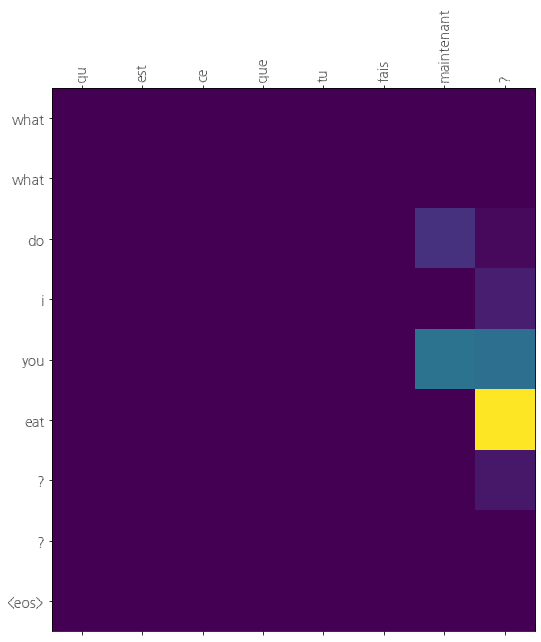

In [ ]:
#Do you work at a City bank?
translate(u'씨티은행에서 일하세요?')

Input: je parle francais .
Predicted translation:  speak i french french . . <eos>


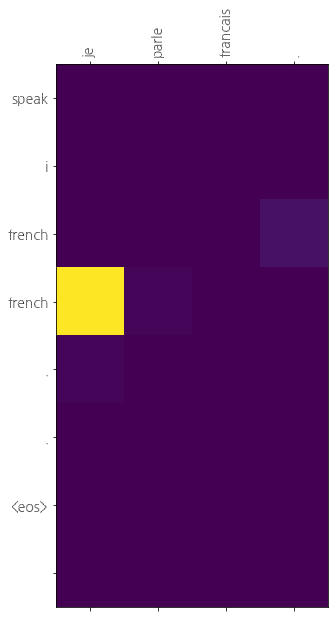

In [ ]:
#As a result of the meeting with A company that we recently had, the contract time will be postponed a bit.
translate(u'얼마 전 가진 A사와의 회의 결과, 본계약의 계약 시점은 약간 지연된다고 합니다.')

Input: la vie est amusante .
Predicted translation:  life life is is fun fun . . <eos>


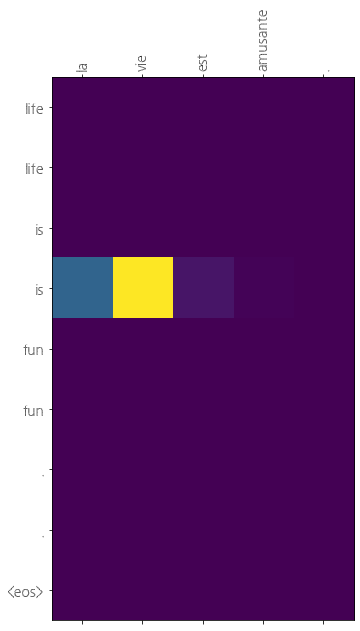

In [ ]:
# They said they wanted to come to Korea directly, not via Japan.
translate(u'그들은 일본을 경유하지 않고 바로 한국에 오고 싶다고 말했어요.')

Input: je n en suis pas si sur !
Predicted translation:  why i i m am so not sure .


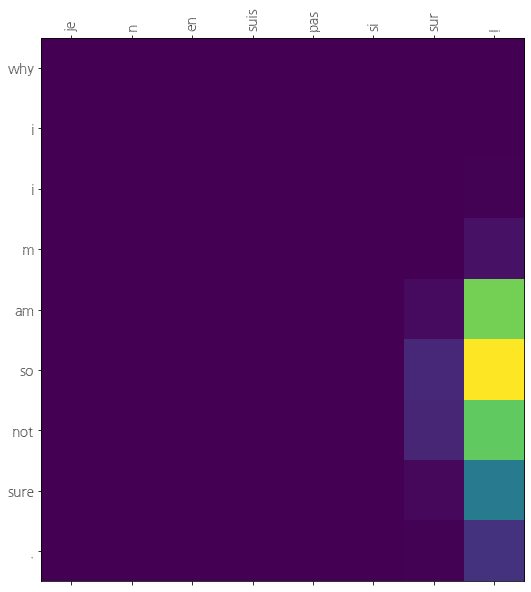

In [ ]:
# First of all, I like autumn because it is cool.
translate('우선, 나는 가을이 시원해서 좋습니다.')

In [ ]:
def translate_train(seq_index):
  input_seq = encoder_input_train[seq_index: seq_index + 1]

  sentence = seq_to_src(encoder_input_train[seq_index]).strip()
  _, result, attention_plot = decode_sequence(sentence)

  print('Input: %s' % (sentence))
  print("Right translation :",seq_to_tar(decoder_input_train[seq_index]))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

[9481 2515 7858 5655 6949]
Input: biscuit est mon chien .
Right translation : <sos> cookie is my dog . 
Predicted translation:  my cookie dog is is good . . <eos>


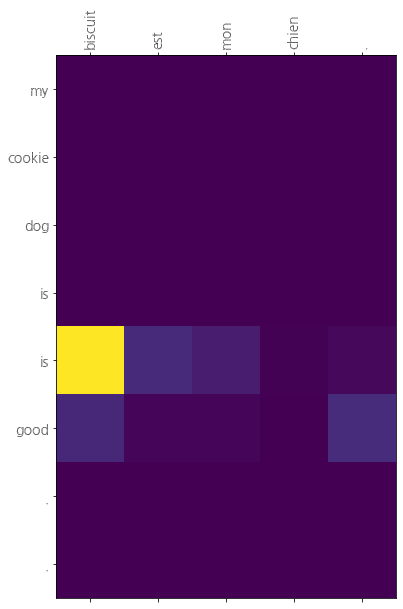

--------------------------------------------------
Input: l ecole est finie .
Right translation : <sos> school is out . 
Predicted translation:  school school is is over over . . <eos>


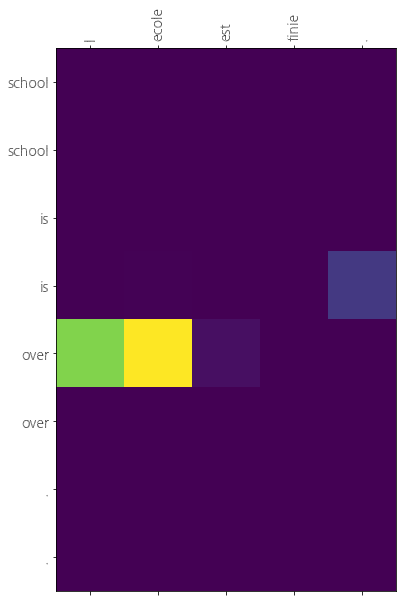

--------------------------------------------------
Input: saute .
Right translation : <sos> jump . 
Predicted translation:  jump jump . ! <eos>


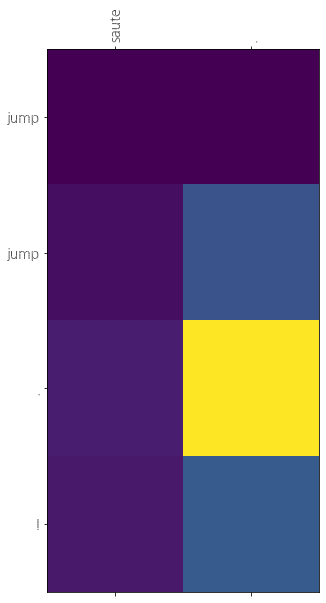

--------------------------------------------------
Input: levez les mains !
Right translation : <sos> raise your hands . 
Predicted translation:  raise raise your your hands hands . ? <eos>


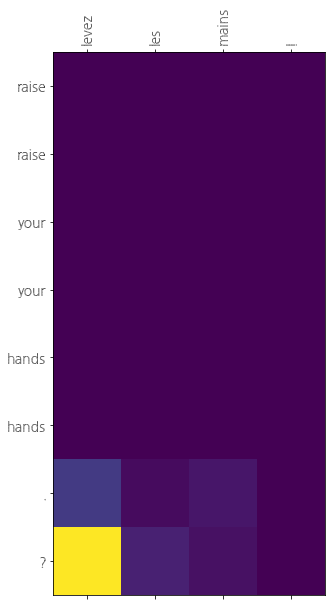

--------------------------------------------------
Input: la maison est blanche .
Right translation : <sos> the house is white . 
Predicted translation:  the the house car is . . <eos>


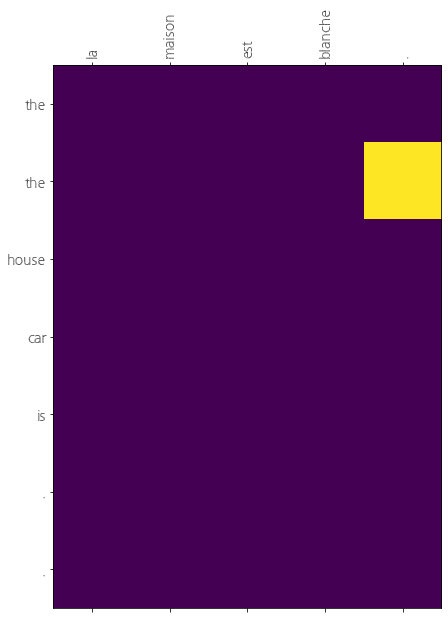

--------------------------------------------------


In [ ]:
indices = np.random.randint(10000, size = (5,))
print(indices)
for seq_index in indices:
    translate_train(seq_index)
    print("-"*50)

In [ ]:
def translate_test(seq_index):
  input_seq = encoder_input_test[seq_index: seq_index + 1]

  sentence = seq_to_src(encoder_input_test[seq_index]).strip()
  _, result, attention_plot = decode_sequence(sentence)

  print('Input: %s' % (sentence))
  print("Right translation :",seq_to_tar(decoder_input_train[seq_index]))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: tom est gate .
Right translation : <sos> are you saying no ? 
Predicted translation:  tom tom is is drunk drunk . . <eos>


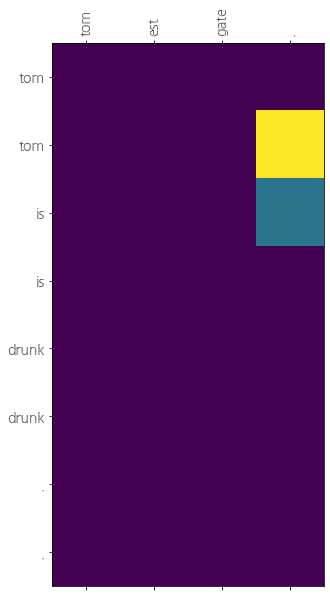

--------------------------------------------------
Input: tom y est il alle seul ?
Right translation : <sos> they must be fake . 
Predicted translation:  tom did is it it . . <eos>


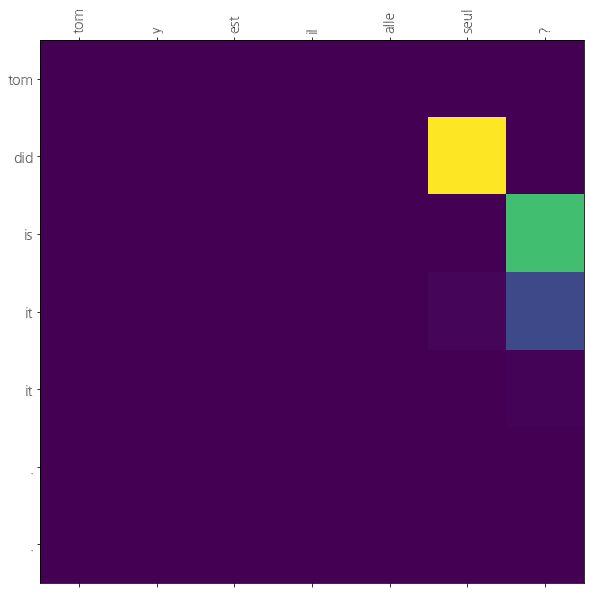

--------------------------------------------------
Input: les gens sont idiots .
Right translation : <sos> he cheated on me . 
Predicted translation:  people go are there . . <eos>


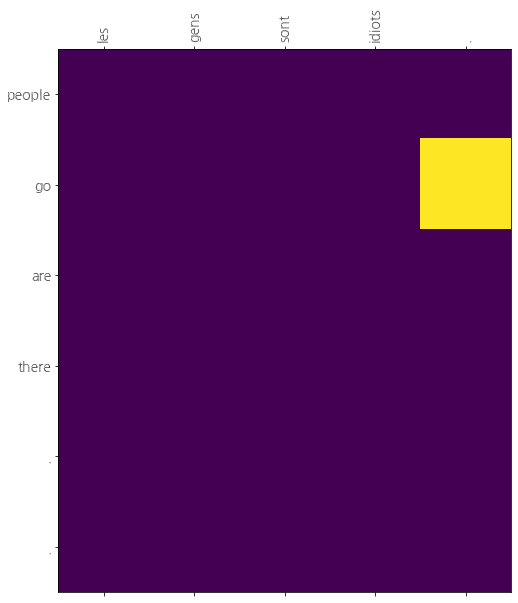

--------------------------------------------------
Input: tu es magnifique .
Right translation : <sos> write it down . 
Predicted translation:  you you fainted fainted . . <eos>


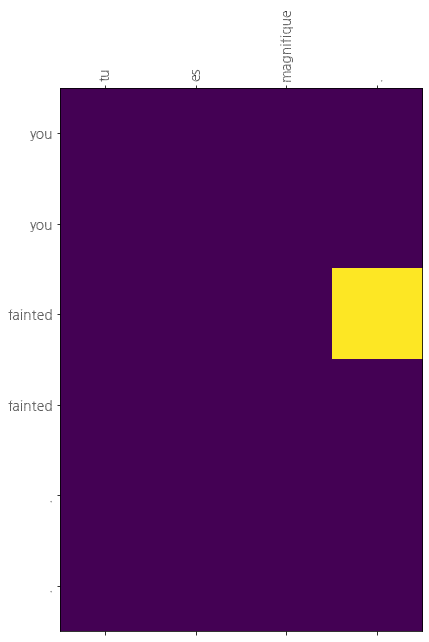

--------------------------------------------------
Input: il a ete super .
Right translation : <sos> i went inside . 
Predicted translation:  was it it was was easy easy . .


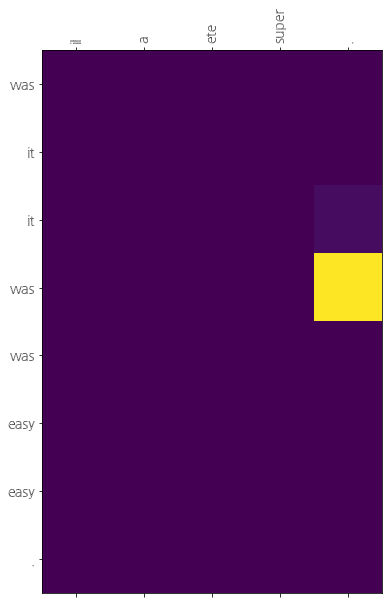

--------------------------------------------------


In [ ]:
for seq_index in [10, 200, 303, 1005, 3000]:
  translate_test(seq_index)
  print("-"*50)

## BLEU Score (Bilingual Evaluation Understudy Score)
기계 번역의 성능이 얼마나 뛰어난가를 측정하기 위해 사용되는 대표적인 방법 중 하나인 BLEU(Bilingual Evaluation Understudy)를 측정해봅시다. 
- 논문 : BLEU: a Method for Automatic Evaluation of Machine Translation
- BLEU 점수는 기계 번역된 텍스트와 고품질 참조 번역 세트의 유사성을 측정하는 0과 1 사이의 숫자입니다. 
    - 값이 0이면 기계 번역된 출력이 참조 번역과 겹치는 부분이 없는 것을 의미하고(저품질)
    - 1이면 참조 번역과 완벽하게 겹치는 것을 의미합니다(고품질)

- BLEU 설명 
    - https://jrc-park.tistory.com/273
    - https://wikidocs.net/31695
    - https://cloud.google.com/translate/automl/docs/evaluate?hl=ko#bleu

In [ ]:
import numpy as np
from collections import Counter
from nltk import ngrams

BLEU는 기계 번역 결과와 사람이 직접 번역한 결과가 얼마나 유사한지 비교하여 번역에 대한 성능을 측정하는 방법입니다. 

In [ ]:
import nltk.translate.bleu_score as bleu

candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands',
]

print('패키지 NLTK의 BLEU :',bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split()))

패키지 NLTK의 BLEU : 0.41180376356915777


In [ ]:
ref_train = [seq_to_tar(sen) for sen in decoder_input_train[:100]]
ref_test = [seq_to_tar(sen) for sen in decoder_input_test[:100]]

In [ ]:
def translate_bleu(seq_index):
  input_seq = encoder_input_test[seq_index: seq_index + 1]

  sentence = seq_to_src(encoder_input_test[seq_index]).strip()
  _, result, attention_plot = decode_sequence(sentence)
  return result.strip(" <eos>")

In [ ]:
from tqdm.notebook import tqdm 

pred_test = []
for idx in tqdm(range(len(encoder_input_test[:100]))):
    pred_test.append(translate_bleu(idx))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
bleu_score = 0
for ref, pred in zip(ref_test, pred_test):
    if len(ref) == 0 or len(pred) == 0:
        continue
    bleu_score += bleu.sentence_bleu(ref, pred)

bleu_score = bleu_score/len(ref_test)
bleu_score

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

1.384587660925429e-231

### Reference

- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
- https://wikidocs.net/86900
- https://www.tensorflow.org/tutorials/text/nmt_with_attention?hl=ko#%ED%9B%88%EB%A0%A8%EB%90%9C_%EB%AA%A8%EB%8D%B8%EB%A1%9C_%EB%B2%88%EC%97%AD%ED%95%98%EA%B8%B0